
# **The objective of this project is to predict 3 months of item-level sales data at different store locations.**

## **Data fields**

  ### **Data fields**

  ###  date - Date of the sale data. There are no holiday effects or store closures.
   ### store - Store ID
   ### item - Item ID
   ### sales - Number of items sold at a particular store on a particular date.



In [3]:
# Importing necessary libraries
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/train.csv')

# Display the first few rows of the dataset
print(data.head())




         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


In [6]:
# Display the last few rows of the dataset
print(data.tail())

              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82


In [7]:
# Get information about the dataset
print(data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None


In [8]:

# Summary statistics of numerical columns
print(data.describe())

               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000


In [9]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

In [10]:
# Check for missing values
print(data.isnull().sum())

date     0
store    0
item     0
sales    0
dtype: int64


In [11]:
# Check for duplicates
print(data.duplicated().sum())

0


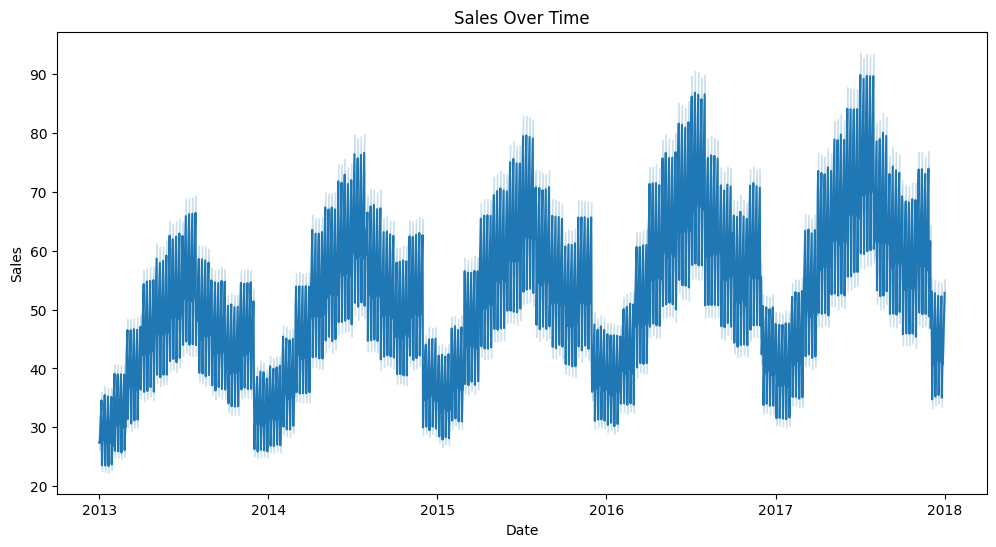

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series plot of sales
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=data)
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()




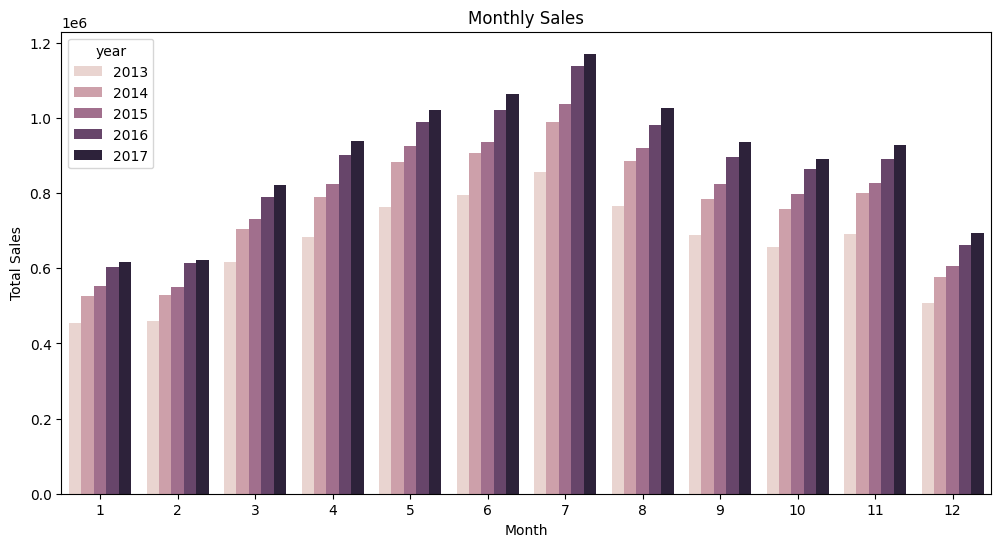

In [18]:
# Monthly sales plot
plt.figure(figsize=(12, 6))
monthly_sales = data.groupby(['year', 'month'])['sales'].sum().reset_index()
sns.barplot(x='month', y='sales', hue='year', data=monthly_sales)
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

In [12]:
# Extract year, month, day, and day of the week from the date column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek


In [13]:
# Define the number of lag features
num_lags = 7  # for example, consider the past 7 days

# Create lag features for the target variable (sales)
for i in range(1, num_lags + 1):
    data[f'sales_lag_{i}'] = data.groupby(['store', 'item'])['sales'].shift(i)


In [14]:
# Encode categorical variables (store and item IDs)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['store_encoded'] = label_encoder.fit_transform(data['store'])
data['item_encoded'] = label_encoder.fit_transform(data['item'])


In [20]:
# Find the minimum date in the dataset
min_date = data['date'].min()

# Set the split date to be 70% of the maximum date and 30% of the range of dates
split_date = min_date + pd.Timedelta(days=int(0.7 * (data['date'].max() - min_date).days))

# Split the dataset into training and testing sets
train = data[data['date'] < split_date]
test = data[data['date'] >= split_date]

# Display the number of rows in the training and testing sets
print("Number of rows in training set:", len(train))
print("Number of rows in testing set:", len(test))


Number of rows in training set: 638500
Number of rows in testing set: 274500


In [ ]:
# Model Selection and Training (Using Random Forest)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define features and target variable
features = ['store', 'item', 'year', 'month', 'day', 'day_of_week']
target = 'sales'

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(train[features], train[target])

# Step 5: Model Evaluation
# Make predictions on the test set
predictions = rf_model.predict(test[features])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test[target], predictions)
print('Mean Absolute Error:', mae)


In [22]:
# Model Selection and Training (Including CatBoost)

from catboost import CatBoostRegressor

# Initialize CatBoost model
catboost_model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='MAE', random_state=42)

# Train the CatBoost model
catboost_model.fit(train[features], train[target], verbose=100)

# Step 5: Model Evaluation
# Make predictions on the test set using CatBoost
catboost_predictions = catboost_model.predict(test[features])

# Calculate Mean Absolute Error (MAE) for CatBoost
catboost_mae = mean_absolute_error(test[target], catboost_predictions)
print('CatBoost Mean Absolute Error:', catboost_mae)



0:	learn: 20.8973146	total: 326ms	remaining: 5m 25s
100:	learn: 9.4640197	total: 9.88s	remaining: 1m 27s
200:	learn: 7.1611814	total: 22.1s	remaining: 1m 27s
300:	learn: 6.5602596	total: 36.6s	remaining: 1m 25s
400:	learn: 6.2316344	total: 47s	remaining: 1m 10s
500:	learn: 6.0396537	total: 59.1s	remaining: 58.8s
600:	learn: 5.9022107	total: 1m 7s	remaining: 45.1s
700:	learn: 5.8105321	total: 1m 18s	remaining: 33.4s
800:	learn: 5.7443888	total: 1m 28s	remaining: 22.1s
900:	learn: 5.6823683	total: 1m 39s	remaining: 10.9s
999:	learn: 5.6399763	total: 1m 48s	remaining: 0us
CatBoost Mean Absolute Error: 6.810928657253913


In [23]:
print('Random Forest Mean Absolute Error:', mae)
print('CatBoost Mean Absolute Error:', catboost_mae)


Random Forest Mean Absolute Error: 7.55332160291439
CatBoost Mean Absolute Error: 6.810928657253913


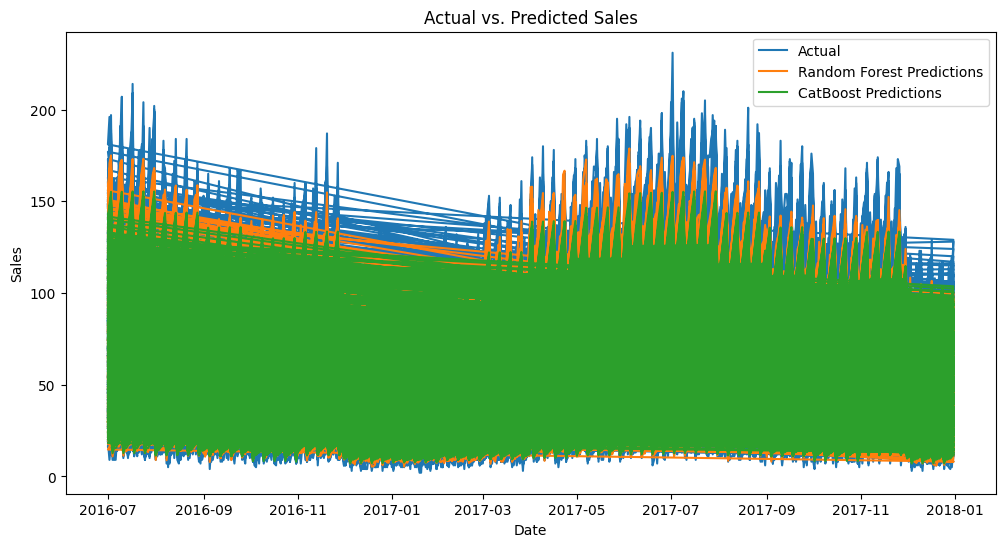

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test['date'], test[target], label='Actual')
plt.plot(test['date'], predictions, label='Random Forest Predictions')
plt.plot(test['date'], catboost_predictions, label='CatBoost Predictions')
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [27]:
# Define future dates for prediction (next three months)
future_dates = pd.date_range(start='2024-04-01', end='2024-06-30')

# Define store and item values (assuming only one store and one item for simplicity)
store_value = test['store'].iloc[0]
item_value = test['item'].iloc[0]

# Create a DataFrame with future dates, store, and item
future_data = pd.DataFrame({
    'date': future_dates,
    'store': store_value,
    'item': item_value
})

# Extract year, month, day, and day of week from future dates
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['day'] = future_data['date'].dt.day
future_data['day_of_week'] = future_data['date'].dt.dayofweek

# Make predictions for the future dates using Random Forest model
future_rf_predictions = rf_model.predict(future_data[features])

# Make predictions for the future dates using CatBoost model
future_catboost_predictions = catboost_model.predict(future_data[features])

# Prepare submission file for Random Forest predictions
rf_submission = pd.DataFrame({
    'date': future_dates,
    'store': store_value,
    'item': item_value,
    'sales': future_rf_predictions
})

# Prepare submission file for CatBoost predictions
catboost_submission = pd.DataFrame({
    'date': future_dates,
    'store': store_value,
    'item': item_value,
    'sales': future_catboost_predictions
})

# Save submission files
rf_submission.to_csv('rf_sales_predictions.csv', index=False)
catboost_submission.to_csv('catboost_sales_predictions.csv', index=False)


In [28]:
# Print the Random Forest submission file
print("Random Forest Submission File:")
print(rf_submission.head())

# Print the CatBoost submission file
print("\nCatBoost Submission File:")
print(catboost_submission.head())


Random Forest Submission File:
        date  store  item  sales
0 2024-04-01      1     1  19.07
1 2024-04-02      1     1  22.81
2 2024-04-03      1     1  23.38
3 2024-04-04      1     1  20.11
4 2024-04-05      1     1  22.67

CatBoost Submission File:
        date  store  item      sales
0 2024-04-01      1     1  16.568437
1 2024-04-02      1     1  20.835397
2 2024-04-03      1     1  20.844473
3 2024-04-04      1     1  22.306048
4 2024-04-05      1     1  24.207252
